In this short tutorial I will show you how easy and powerful it is to simulate a cyclic voltammogram using pyecsim.

First,let's import pyecsim and matplotlib:

In [1]:
import matplotlib.pyplot as plt
import pyecsim as ecs

Instantiate a Simulation object, and set the verbosity parameter to True so that we get full output from the simulator:

In [2]:
sim = ecs.Simulation(True)

Let's start with simulating a CV of simple (electrochemically reversible) 1-electron redox couple. We define two species: the one that you add to the flask (__ox__, with a non-zero concentration of 1.0 mol/m^3) and the reduced species __red__ that will form when we reduce __ox__. The diffusion coefficients of both species we will set to 10^9 m2/s:

In [3]:
ox = ecs.Species('oxidised species', 1.0, 1.0e-9) # name, initial concentration, diffusion coefficient
red = ecs.Species('reduced species', 0.0, 1.0e-9)

Then we have to define the electron transfer that is going to happen, which has to be defined using Butler-Volmer parameters. We take a fully reversible system (k_e > 1.0), alpha 0.5, n = 1 electron at a potential of -0.5 V. We create the Redox object, `enable()` it and add it to 'the system' `sim.sys`:

In [4]:
redox1 = ecs.Redox(ox, red, 1, -0.5, 1.0, 0.5).enable() # ox, red, n, E, k_e, alpha
sim.sys.addRedox(redox1)

We have to define an electrode geometry (disk, square, sphere, etc.) and size which we do on the electrode object `sim.el`:

In [5]:
sim.el.disk(1.0e-3) # disk electrode with a radius of 1 mm

We also have to set the parameters of the cyclic voltammotry experiment. Let's start the scan at 0.0 V, scan to -1.0 V and then back to 0.0 V at a scan rate of 0.1 V/s. Again we have an in-built object `sim.exper` with handy methods that do this for us:

In [6]:
sim.exper.setScanPotentials(0.0, [-1.0], 0.0) # potentials [V]: initial, [vertex1, vertex2, ...], final
sim.exper.setScanRate(0.1) # scan rate in [V/s]

Now we have defined everything necessary to run a simulation. The simulation object `sim` has a method `run()` that runs the simulation and returns the simulated potentials and currents. (When run in a terminal, it also outputs information about the simulation, such as the time it took to run it.)

In [7]:
[potential, current] = sim.run()

The simulated cyclic voltammogram is now stored in the `potential` and `current` lists, which we can plot using `matplotlib`:

Text(0, 0.5, 'Current [A]')

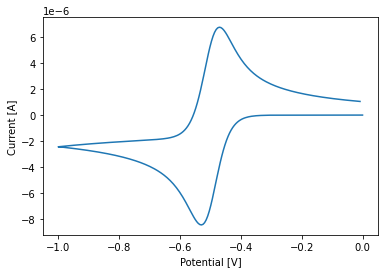

In [8]:
plt.figure()
plt.plot(potential, current)
plt.xlabel('Potential [V]')
plt.ylabel('Current [A]')

To make it a bit more interesting, we can add a follow-up reaction to the reduction step: species __red__ reacts to form species __prod__. To do this, we define a new species __prod__ with a 0 initial concentration:

In [9]:
prod = ecs.Species('reaction product', 0.0, 1.0e-9)

We then have to add a homogeneous reaction. This has the general form __A__+__B__<->__C__+__D__, and since in our case we only have one species on the left and one on the right, we simply put `None` in place of __B__ and __D__. Let's define an irreversible reaction (k_b = 0.0) with a forward rate constant k_f of 1.0 /s (and `enable()` it!):

In [10]:
reaction1 = ecs.Reaction(red, None, prod, None, 1.0, 0.0).enable() # A, B, C, D, k_f, k_b (the 2 rate constants)
sim.sys.addReaction(reaction1)

And then we just run the simulation again:

Text(0, 0.5, 'Current [A]')

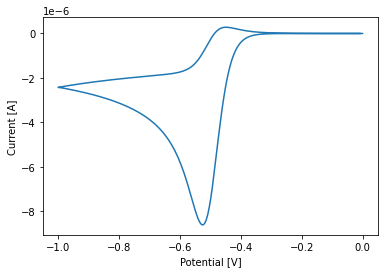

In [11]:
plt.figure()
plt.plot(*sim.run())
plt.xlabel('Potential [V]')
plt.ylabel('Current [A]')

Too easy.

Want to visualize the effect of the forward rate constant? Check this out:

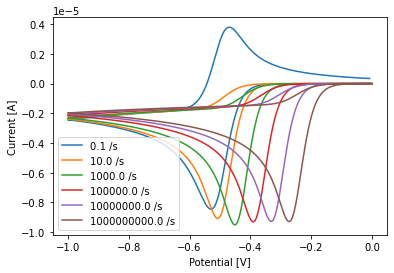

In [12]:
plt.figure()
for k_f in [1e-1, 1e1, 1e3, 1e5, 1e7, 1e9]:
    reaction1.setKf(k_f)
    plt.plot(*sim.run(), label=f'{k_f} /s')
plt.xlabel('Potential [V]')
plt.ylabel('Current [A]')
plt.legend()

Oh man that's wicked! Want to visualize the effect of the scan rate on this reaction?

In [13]:
plt.figure()
reaction1.setKf(1.0) # put it back to where it was
for scan_rate in [0.1, 1.0, 10.0]:
    sim.exper.setScanRate(scan_rate)
    [potential, current] = sim.run()
    plt.plot(potential, [i/scan_rate**0.5 for i in current],
             label=f'{scan_rate} V/s') # scale current by sqrt(scan_rate)
plt.xlabel('Potential [V]')
plt.ylabel('Current/sqrt(scan rate) [A]')
plt.legend()

We will now disable the homogeneous reaction and set the scan rate back to 0.1 V/s.

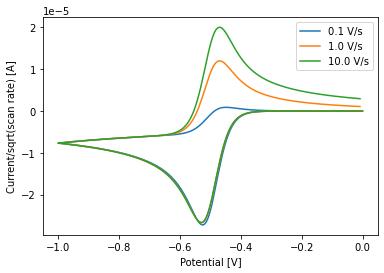

In [14]:
reaction1.disable()
sim.exper.setScanRate(0.1)

We're going to visualize the effect of k_e (the heterogeneous rate constant) on the simple 1-electron redox step, or, electrochemical (ir)reversibility:

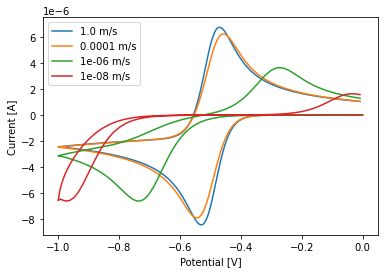

In [15]:
plt.figure()
for k_e in [1e0, 1e-4, 1e-6, 1e-8]:
    redox1.setKe(k_e)
    plt.plot(*sim.run(), label=f'{k_e} m/s')
plt.xlabel('Potential [V]')
plt.ylabel('Current [A]')
plt.legend()

Did someone say a square wave scheme? Why not! But it is dinner time and I am hungry. So I leave this one (and many more!) up to you.